<a href="https://colab.research.google.com/github/SebastianArriagada/computer-vision/blob/main/mini_proyect_sport_balls/image_classification_mini_proyect_sport_balls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download database from Kaggle \
It requires the file "kaggle.json", obtained from kaggle.com -> account -> Create New API Token

In [6]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/balls-image-classification
!mkdir ~/.data
!unzip balls-image-classification.zip -d data --quiet

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 180M/183M [00:03<00:00, 40.6MB/s]
100% 183M/183M [00:04<00:00, 47.7MB/s]
mkdir: cannot create directory ‘/root/.data’: File exists
Archive:  balls-image-classification.zip
  inflating: data/EfficientNetB3-balls-99.23.h5  
  inflating: data/balls.csv          
  inflating: data/class_dict.csv     
  inflating: data/test/baseball/1.jpg  
  inflating: data/test/baseball/2.jpg  
  inflating: data/test/baseball/3.jpg  
  inflating: data/test/baseball/4.jpg  
  inflating: data/test/baseball/5.jpg  
  inflating: data/test/basketball/1.jpg  
  inflating: data/test/basketball/2.jpg  
  inflating: data/test/basketball/3.jpg  
  inflating: data/test/basketball/4.jpg  
  inflating: data/test/basketball/5.jpg  
  inflating: data/test/beachballs/1.jpg  
  inflating: data/test/beachballs/2.jpg  
  inflating: data/test/beachballs/3.jpg  
  inflating: data/test/beachballs/4.jpg  
  inflating: data/test/beachballs/5.jpg  
  inflating: data

Looking inside the folders to see how many examples there are of each label

In [7]:
from pathlib import Path
from os import listdir
from tabulate import tabulate
import numpy as np 
# prefix components:
space =  '    '
branch = '│   '
# pointers:
tee =    '├── '
last =   '└── '

def tree(dir_path: Path, prefix: str='', onlyNumberOfFiles = False):
    """A recursive generator, given a directory Path object
    will yield a visual tree structure line by line
    with each line prefixed by the same characters
    """    
    if onlyNumberOfFiles:
      yield f'{prefix}{last} {len(listdir(dir_path))}'
    else:
      contents = list(dir_path.iterdir())
      pointers = [tee] * (len(contents) - 1) + [last]
      for pointer, path in zip(pointers, contents):
          yield prefix + pointer + path.name
          if path.is_dir(): # extend the prefix and recurse:
              extension = branch if pointer == tee else space 
              # i.e. space because last, └── , above so no more |
              yield from tree(path, prefix=prefix+extension, onlyNumberOfFiles = True)

trainTree = tree(Path.home() / '/content/data/train')
testTree = tree(Path.home() / '/content/data/test')
validTree = tree(Path.home() / '/content/data/valid')
train, test, valid = [], [], []
for lineTrain, lineTest, lineValid in zip(trainTree, testTree, validTree):
    train.append(lineTrain)
    test.append(lineTest)
    valid.append(lineValid)
    #print(lineTrain, lineTest)

print(tabulate(zip(train ,test, valid), headers=['Train', 'Test', 'Valid']))

Train                Test                 Valid
-------------------  -------------------  -------------------
├── bowling ball     ├── bowling ball     ├── bowling ball
│   └──  145         │   └──  5           │   └──  5
├── golf ball        ├── golf ball        ├── golf ball
│   └──  106         │   └──  5           │   └──  5
├── beachballs       ├── beachballs       ├── beachballs
│   └──  92          │   └──  5           │   └──  5
├── medicine ball    ├── medicine ball    ├── medicine ball
│   └──  77          │   └──  5           │   └──  5
├── eyeballs         ├── eyeballs         ├── eyeballs
│   └──  139         │   └──  5           │   └──  5
├── paint balls      ├── paint balls      ├── paint balls
│   └──  32          │   └──  5           │   └──  5
├── wrecking ball    ├── wrecking ball    ├── wrecking ball
│   └──  69          │   └──  5           │   └──  5
├── meat ball        ├── meat ball        ├── meat ball
│   └──  137         │   └──  5           │   └──  5
├── s

Building the database from the folders, taking the name of each folder as a label

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import os
import numpy as np
import tensorflow as tf

# Training step 

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '/content/data/train',
    labels='inferred',
    label_mode='categorical' ,
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '/content/data/valid',
    labels='inferred',
    label_mode= 'categorical' ,
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 3051 files belonging to 26 classes.
Found 130 files belonging to 26 classes.


Create model in Keras using the structure of VGG16

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Defiing a model using Keras 
model = keras.Sequential([
    # give the input dimensions in the first layer
    # [height, width, color channels(RGB)]
    layers.InputLayer(input_shape=[128, 128, 3]),
                          
    # Data Augmentation
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    #layers.RandomContrast(0.2),
    layers.RandomZoom(0.5),

    # First Convolutional Block
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same',),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(pool_size = (2,2), strides=(2,2)),

    # Second Convolutional Block
    layers.Conv2D(filters=128, kernel_size=(3,3),activation="relu", padding='same'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(pool_size = (2,2), strides=(2,2)),

    # Third Convolutional Block
    layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding='same'),
    layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding='same'),
    layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(pool_size = (2,2), strides=(2,2)),

    # Fourth Convolutional Block
    layers.Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding='same'),
    layers.Conv2D(filters=512, kernel_size=(3,3),activation="relu", padding='same'),
    layers.Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(pool_size = (2,2), strides=(2,2)),

    # Fifth Convolutional Block
    layers.Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding='same'),
    layers.Conv2D(filters=512, kernel_size=(3,3),activation="relu", padding='same'),
    layers.Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(pool_size = (2,2), strides=(2,2)),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=4096, activation="relu"),
    layers.Dropout(0.8),
    layers.Dense(units=4096, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(units=26, activation="softmax"),
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_40 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                 

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Setting save options
checkpoint = ModelCheckpoint("vgg16.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

# Setting training options
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model 
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    callbacks=[checkpoint],
)

# Display the training history 
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

test_loss, test_acc = model.evaluate(ds_valid, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 3.2515 - accuracy: 0.0485
Epoch 00001: val_accuracy improved from -inf to 0.03846, saving model to vgg16.h5
48/48 [==============================] - 54s 790ms/step - loss: 3.2515 - accuracy: 0.0485 - val_loss: 3.2617 - val_accuracy: 0.0385
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 3.2288 - accuracy: 0.0531
Epoch 00002: val_accuracy did not improve from 0.03846
48/48 [==============================] - 30s 618ms/step - loss: 3.2288 - accuracy: 0.0531 - val_loss: 3.2938 - val_accuracy: 0.0385
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 3.2268 - accuracy: 0.0531
Epoch 00003: val_accuracy did not improve from 0.03846
48/48 [==============================] - 30s 619ms/step - loss: 3.2268 - accuracy: 0.0531 - val_loss: 3.2965 - val_accuracy: 0.0385
Epoch 4/50
48/48 [==============================] - ETA: 0s - loss: 3.2223 - accuracy: 0.0570
Epoch 00004: val_accuracy did not im

In [ ]:
# Loads the weights
model.load_weights('/content/vgg16.h5')

# Re-evaluate the model
ds_test_ = image_dataset_from_directory(
    '/content/data/test',
    labels='inferred',
    label_mode= 'categorical' ,
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)
ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

loss, acc = model.evaluate(ds_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Found 130 files belonging to 26 classes.
3/3 - 1s - loss: 2.4497 - accuracy: 0.5615 - 636ms/epoch - 212ms/step
Restored model, accuracy: 56.15%


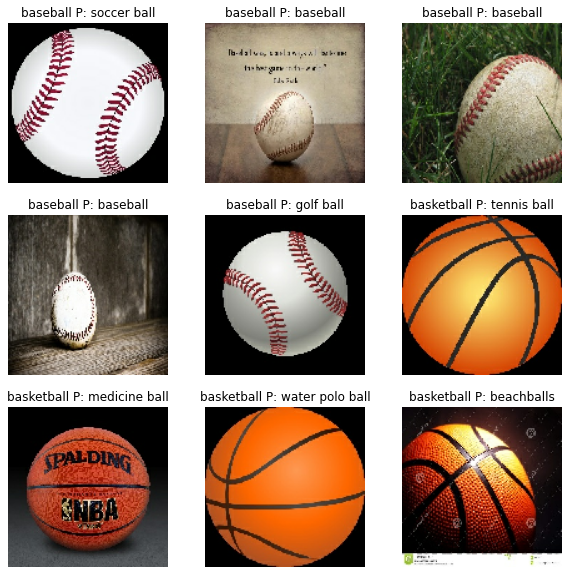

In [ ]:
# Viewing results
image_batch = ds_valid_.take(1)
predictions = model.predict(image_batch)
plt.figure(figsize=(10, 10))
for images, labels in image_batch:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = list(np.array(tf.cast(labels[i], tf.int32)))
    index = label.index(1)
    predicted_label = np.argmax(predictions[i])
    color = (0,0,255) if class_names[index ] == class_names[predicted_label] else (0,255,0)
    plt.title("T:", class_names[index ] + " P:" + class_names[predicted_label] )
    plt.axis("off")